In [1]:
import math
import matplotlib.pyplot as plt
import random
from typing import Callable, Tuple, Any
import numpy as np
import statistics

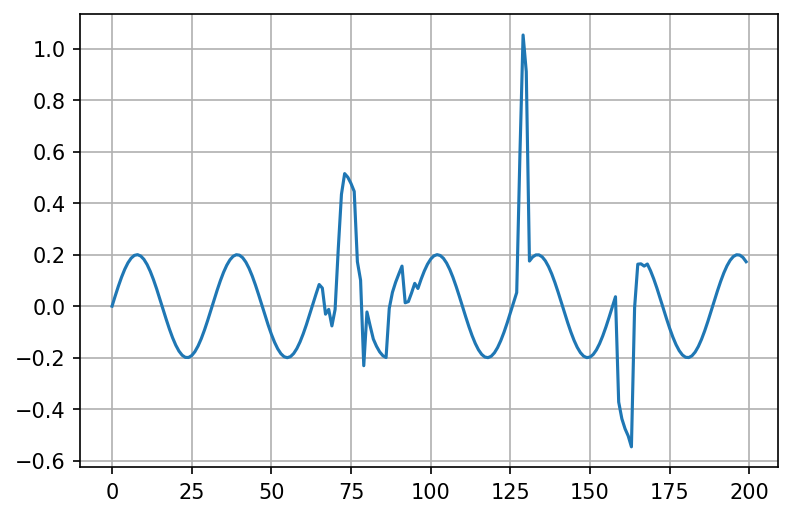

In [3]:
class SignalGenerator:
    data: list[float] = []
    x_list: list[int] = []
    file_name: str = "out.txt"

    def __init__(self, x_start: int = 0, x_end: int = 100) -> None:
        self._set_x_list(x_start, x_end)

    def _set_x_list(self, x_start: int, x_end: int):
        self.x_list = [x for x in range(x_start, x_end)]
        return self

    def _merge(self, data: list[float]):
        new_data = []
        for i in range(len(data)):
            current_data_item = 0
            try:
                current_data_item = self.data[i]
            except IndexError:
                pass
            new_data.append(data[i] + current_data_item)
        self.data = new_data

    def sin(self, a: float = 1, b: float = 1):
        self._merge([a * math.sin(x * b) for x in self.x_list])
        return self

    def cos(self, a: float = 1, b: float = 1):
        self._merge([a * math.cos(x * b) for x in self.x_list])
        return self

    def square_vawe(self, frequency: int = 10, height: int = 1):
        self._merge([height if (x % frequency) >= (frequency / 2) else 0 for x in self.x_list])
        return self

    def triangle_vawe(self, p: float = 50):
        self._merge([2 * math.fabs((x / p) - math.floor((x / p) + 0.5)) for x in self.x_list])
        return self

    def noise(self, y_min: float = -1, y_max: float = 1):
        self._merge([random.uniform(y_min, y_max) for _ in self.x_list])
        return self

    def linear(self, a: float = 1, b: float = 1):
        self._merge([a * x + b for x in self.x_list])
        return self

    def const(self, value = 0):
        self._merge([value for _ in self.x_list])
        return self

    def from_function(self, function: Callable[[int], float]):
        self._merge([function(x) for x in self.x_list])
        return self

    def with_peaks(self, 
        count: int = 1, 
        min_value: float = 0, 
        max_value: float = 1, 
        min_width: int = 1, 
        max_width: int = 10,
        direction: int = 1
    ):
        data = [0 for _ in self.x_list]
        for _ in range(count):
            x = random.randint(self.x_list[0], self.x_list[len(self.x_list) - 1])
            y = random.uniform(min_value, max_value)
            peak_y = y
            data[x] = y
            x_count = random.randint(min_width, max_width)
            last_y = min_value
            for i in reversed(range(math.floor(x_count / 2))):
                index = x - i - 1
                if index < 0:
                    continue
                y = random.uniform(last_y, peak_y)
                data[index] = y
                last_y = y
            last_y = peak_y
            for i in range(math.floor(x_count / 2)):
                index = x + i + 1
                if index > len(data) - 1:
                    continue
                y = random.uniform(last_y, min_value)
                data[index] = y
                last_y = y
        data = [y * direction for y in data]
        self._merge(data)
        return self

    def toFile(self):
        with open(self.file_name, 'w') as file:
            file.write(','.join(self.data))
        return self

    def draw(self):
        plt.figure(dpi=150)
        plt.plot(self.x_list, self.data)
        plt.grid()
        plt.show()
        return self

SignalGenerator(0, 200).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2).draw()

In [4]:
class Metric:
  def sum_differences(self, original: list[float], transformed: list[float], use_absolut_value: bool = True) -> float:
    differences = [original[i] - transformed[i] for i in range(len(original))]
    if use_absolut_value:
      differences = map(math.fabs, differences)
    return sum(differences)
  
  def arithmetic_average(self, original: list[float], transformed: list[float]) -> float:
    return self.sum_differences(original, transformed) / len(original)

  def standard_derivative(self, original: list[float], transformed: list[float]) -> float:
    n = len(original)
    return math.sqrt(sum([(original[i] - transformed[i])**2 for i in range(n)]) / n)
    
  def function_field(self, original: list[float], transformed: list[float], normalize: bool = True) -> float:
    original_field, transformed_field = np.trapz(original), np.trapz(transformed)
    return math.fabs(original_field - transformed_field) / (max(original_field, transformed_field) if normalize else 1)

  def min(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    if show_diff:
      return min(original) - min(transformed)
    return min(transformed)

  def max(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    if show_diff:
      return max(original) - max(transformed)
    return max(transformed)

  def median(self, original: list[float], transformed: list[float], show_diff: bool = True) -> float:
    if show_diff:
      return statistics.median(original) - statistics.median(transformed)
    return statistics.median(transformed)
  
  def fft(self, transformed: list[float], show_plot: bool = False) -> Tuple[list[float], Any]:
    transformed_np_array = np.array(transformed)
    sp = np.fft.fft(transformed_np_array)
    freq = np.fft.fftfreq(transformed_np_array.shape[-1])
    if show_plot:
      plt.plot(freq, sp.real, freq, sp.imag)
    return sp, freq

Metric().function_field([1,2,3,4,5,6,7,8,9], [1,1,1,-5,5,6,7,4,11])

0.375

{'original_size': 100, 'compressed_size': 23, 'compression_rate': 0.77}


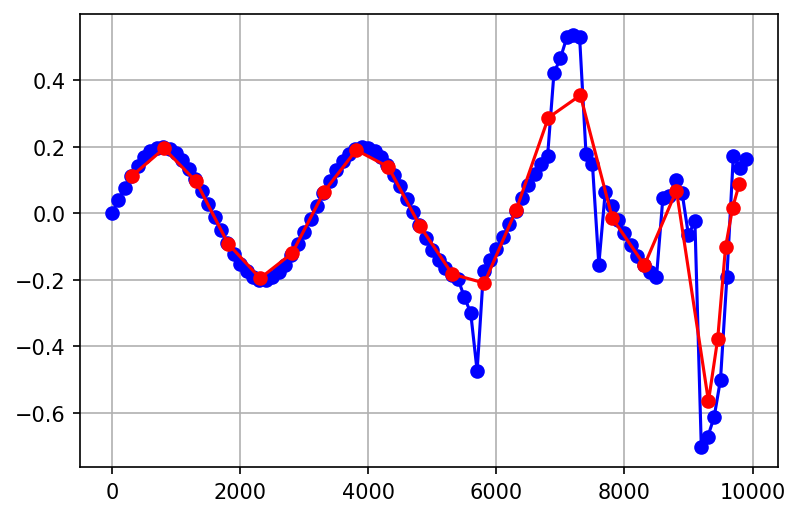

In [112]:
class Measurement:
  value: float
  timestamp: int

  def __init__(self, value: float, timestamp: float):
    self.value = value
    self.timestamp = timestamp

class DataCompressor:
  metric: Metric = Metric()
  original_data: list[Measurement] = []
  compressed_data: list[Measurement] = []

  # todo: create class
  compress_nths_conf = {
    'n': 3
  }

  # todo: create class
  compress_higher_deriveration_conf = {
    'deriveration': 0.05
  }

  # todo: create class
  compress_by_chunk_conf = {
    'chunk_size': 5
  }

  def __init__(self): # metrics config, compression config
    pass # todo
  
  def _fill_with_interpolate(self):
    pass # todo
  
  def valid(self):
    pass # todo

  def compress_nths(self):
    data_len = len(self.original_data)
    for i in range(0, data_len, self.compress_nths_conf['n']):
      self.compressed_data.append(self.original_data[i])
    if data_len % 3 != 0:
      self.compressed_data.append(self.original_data[data_len - 1])
    return self.compressed_data

  def compress_higher_deriveration(self):
    deriveration = self.compress_higher_deriveration_conf['deriveration']
    if len(self.original_data) == 0:
      return
    last_measurement_value = self.original_data[0].value
    for measurement in self.original_data:
      if abs(last_measurement_value - measurement.value) > deriveration:
        self.compressed_data.append(measurement)
        last_measurement_value = measurement.value

  def compress_by_chunk(self):
    chunk_size = self.compress_by_chunk_conf['chunk_size']
    if chunk_size < 1:
      return
    chunk: list[Measurement] = []
    for index, measurement in enumerate(self.original_data):
      if index != 0 and index % chunk_size == 0:
        value_average = chunk[0].value
        timestamp_average = chunk[0].timestamp
        for chunk_index in range(1, len(chunk)):
          value_average = (value_average + chunk[chunk_index].value) / 2
          timestamp_average = (timestamp_average + chunk[chunk_index].timestamp) / 2
        self.compressed_data.append(Measurement(value_average, round(timestamp_average)))
        chunk = []
      else:
        chunk.append(measurement)
    if len(chunk) != 0:
      for item in chunk:
        value_average = (value_average + item.value) / 2
        timestamp_average = (timestamp_average + item.timestamp) / 2
        self.compressed_data.append(Measurement(value_average, round(timestamp_average)))

  def compress_most_interesting_points(self):
    pass

  def compress_with_density(self):
    pass

  def compress(self):
    # todo: check metrics
    self.compress_by_chunk()

  def push(self, measurement: Measurement):
    self.original_data.append(measurement)
  
  def set_data(self, measurements: list[Measurement]):
    self.original_data = measurements

  def clean_data(self):
    self.original_data = []
    self.compressed_data = []

  def vizualize(self, show_compressed: bool = True, show_interpolation: bool = False):
    x_original = [measurement.timestamp for measurement in self.original_data]
    y_original = [measurement.value for measurement in self.original_data]
    plt.figure(dpi=150)
    if show_interpolation:
        plt.plot(x_original, y_original, 'b')
    plt.plot(x_original, y_original, 'bo')
    if show_compressed:
      x_compressed = [measurement.timestamp for measurement in self.compressed_data]
      y_compressed = [measurement.value for measurement in self.compressed_data]
      if show_interpolation:
        plt.plot(x_compressed, y_compressed, 'r')
      plt.plot(x_compressed, y_compressed, 'ro')
    plt.grid()
    plt.show()
    return self

  def get_data(self):
    return [measurement.value for measurement in self.compressed_data]

  def get_stats(self):
    return {
      'original_size': len(self.original_data),
      'compressed_size': len(self.compressed_data),
      'compression_rate': (len(self.original_data) - len(self.compressed_data)) / len(self.original_data)
    }

# signal_generator = SignalGenerator()
# generator = signal_generator.sin()
signal_generator = SignalGenerator(0, 100).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2)
# signal_generator.draw()
data_compressor = DataCompressor()

for index, measurement in enumerate(signal_generator.data):
  data_compressor.push(Measurement(measurement, index * 100))
# data_compressor.set_data([Measurement(i, i*100) for i in range(20)])
data_compressor.compress()
# print(data_compressor.get_data())
print(data_compressor.get_stats())
data_compressor.vizualize(True, True)

In [53]:
import unittest

class TestStringMethods(unittest.TestCase):
  def test_upper(self):
    self.assertEqual('foo'.upper(), 'FOO')

  def test_isupper(self):
    self.assertTrue('FOO'.isupper())
    self.assertFalse('Foo'.isupper())

  def test_split(self):
    s = 'hello world'
    self.assertEqual(s.split(), ['hello', 'world'])
    # check that s.split fails when the separator is not a string
    with self.assertRaises(TypeError):
      s.split(2)

unittest.main(argv=[''], verbosity=2, exit=False)

test_isupper (__main__.TestStringMethods) ... ok
test_split (__main__.TestStringMethods) ... ok
test_upper (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK
